In [1]:
import sys
sys.path.append('../Modules')

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
%matplotlib inline
import NeuralNet as nn

def create_data(n=10):
    x = np.linspace(0, 1, n)[:, None]
    return x, np.sin(2 * np.pi * x) + np.random.normal(scale=0.25, size=(10, 1))

x_train, y_train = create_data()
x = np.linspace(0, 1, 100)[:, None]

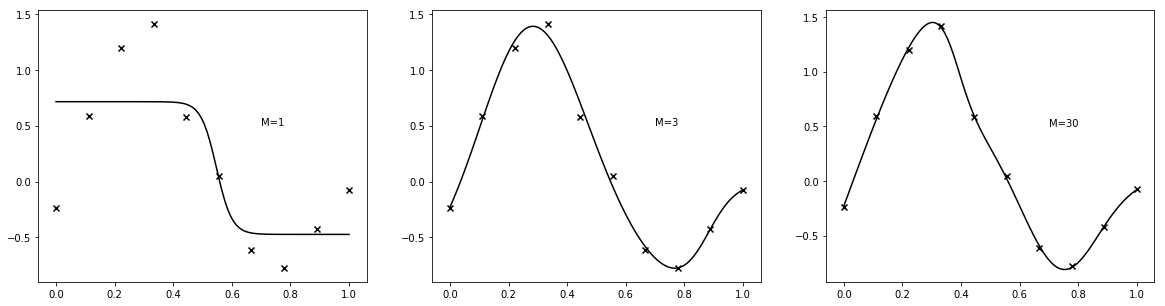

In [2]:
class RegressionNetwork(nn.Network):
    def __init__(self, n_input, n_hidden, n_output):
        truncnorm = st.truncnorm(a=-2, b=2, scale=1)
        super().__init__(
            w1=truncnorm.rvs((n_input, n_hidden)),
            b1=np.zeros(n_hidden),
            w2=truncnorm.rvs((n_hidden, n_output)),
            b2=np.zeros(n_output)
        )

    def __call__(self, x, y=None):
        h = nn.tanh(x @ self.w1 + self.b1)
        self.py = nn.random.Gaussian(h @ self.w2 + self.b2, std=1., data=y)
        return self.py.mu.value

plt.figure(figsize=(20, 5))
for i, m in enumerate([1, 3, 30]):
    plt.subplot(1, 3, i + 1)
    model = RegressionNetwork(1, m, 1)
    optimizer = nn.optimizer.Adam(model, 0.1)
    optimizer.set_decay(0.9, 1000)
    for j in range(10000):
        model.clear()
        model(x_train, y_train)
        log_posterior = model.log_pdf()
        log_posterior.backward()
        optimizer.update()
    y = model(x)
    plt.scatter(x_train, y_train, marker="x", color="k")
    plt.plot(x, y, color="k")
    plt.annotate("M={}".format(m), (0.7, 0.5))
plt.show()

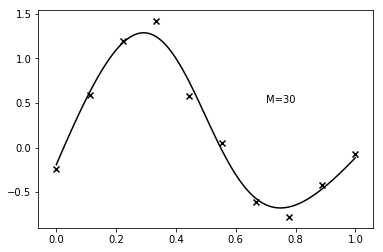

In [3]:
class RegularizedRegressionNetwork(nn.Network):
    
    def __init__(self, n_input, n_hidden, n_output):
        truncnorm = st.truncnorm(a=-2, b=2, scale=1)
        super().__init__(
            w1=truncnorm.rvs((n_input, n_hidden)),
            b1=np.zeros(n_hidden),
            w2=truncnorm.rvs((n_hidden, n_output)),
            b2=np.zeros(n_output)
        )

    def __call__(self, x, y=None):
        self.pw1 = nn.random.Gaussian(0., 1., data=self.w1)
        self.pb1 = nn.random.Gaussian(0., 1., data=self.b1)
        self.pw2 = nn.random.Gaussian(0., 1., data=self.w2)
        self.pb2 = nn.random.Gaussian(0., 1., data=self.b2)
        h = nn.tanh(x @ self.w1 + self.b1)
        self.py = nn.random.Gaussian(h @ self.w2 + self.b2, std=0.1, data=y)
        return self.py.mu.value
    
model = RegularizedRegressionNetwork(1, 30, 1)
optimizer = nn.optimizer.Adam(model, 0.1)
optimizer.set_decay(0.9, 1000)
for i in range(10000):
    model.clear()
    model(x_train, y_train)
    log_posterior = model.log_pdf()
    log_posterior.backward()
    optimizer.update()
y = model(x)
plt.scatter(x_train, y_train, marker="x", color="k")
plt.plot(x, y, color="k")
plt.annotate("M=30", (0.7, 0.5))
plt.show()    